**Contents

1. Importing libraries
2. Data wrangling and EDA
3. Feature aggregation and prepare data for modeling
4. Setting up models and evaluation metrics 
A. Linear Regressor 
B. Ridge Regressor 
C. Lasso Regressor 
D. SVM Linear Regressor 
E. SVM Polynomial Regressor
F. Decision Tree Regressor
G. Random Forest Regressor
H. Adaboost Regressor
I. Neural Networks
5. Selecting modesl and fine_tuning hyperparameters
6. Evaluate final models on test set
7. Result and feature importance analysis
8. Reference

1. Importing libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
from collections import Counter,OrderedDict,defaultdict
import itertools



from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import LinearSVR, SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor


from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score,GridSearchCV,RandomizedSearchCV
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from keras.layers import Dropout
from keras.optimizers import SGD



from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")


2. Data wrangling and EDA
The project datasets are from Kaggle M5 Walmart cometition:
https://www.kaggle.com/c/m5-forecasting-accuracy/overview

After talking with my mentor, we agreed that I just do the annual sales number forecast rather than the daily sales forecast because of my limited knowledge in time series right now.

In [4]:
#load the sales data first
df = pd.read_csv('/Users/irislu/Downloads/capstone2/m5-forecasting-accuracy/sales_train_evaluation.csv')
df

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,4,0,0,0,0,3,3,0,1
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,1,2,1,1,0,0,0,0,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,2,0,0,0,2,3,0,1
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,1,0,4,0,1,3,0,2,6
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,2,1,0,0,2,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,FOODS_3_823_WI_3_evaluation,FOODS_3_823,FOODS_3,FOODS,WI_3,WI,0,0,2,2,...,1,0,3,0,1,1,0,0,1,1
30486,FOODS_3_824_WI_3_evaluation,FOODS_3_824,FOODS_3,FOODS,WI_3,WI,0,0,0,0,...,0,0,0,0,0,0,1,0,1,0
30487,FOODS_3_825_WI_3_evaluation,FOODS_3_825,FOODS_3,FOODS,WI_3,WI,0,6,0,2,...,0,0,1,2,0,1,0,1,0,2
30488,FOODS_3_826_WI_3_evaluation,FOODS_3_826,FOODS_3,FOODS,WI_3,WI,0,0,0,0,...,1,1,1,4,6,0,1,1,1,0


In [5]:
# There are 30490 records
df.id.count()

30490

In [6]:
# There are 3029 unique items, and there are 10 stores, which means each of these 3029 items all has a record row in each store
df.item_id.nunique()

3049

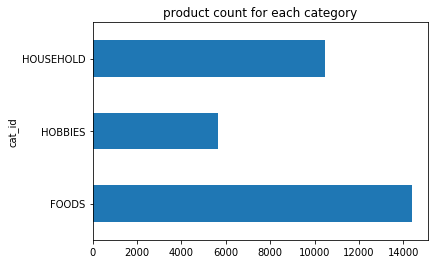

In [7]:
# let's see how many products under each category. It seems food products are the most recorded in the dataset
df.groupby('cat_id').id.count().plot(kind='barh',title='product count for each category')

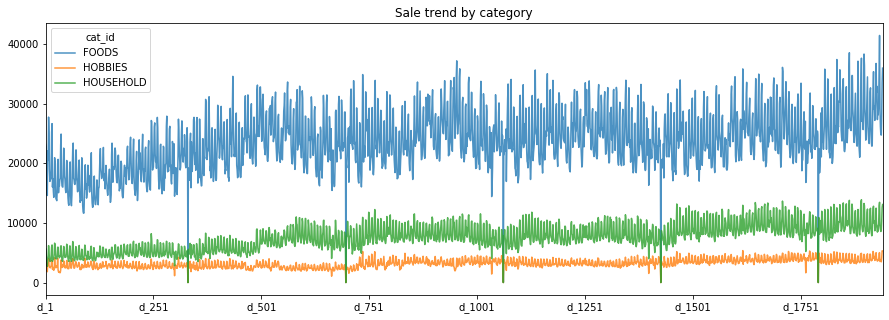

In [8]:
#Let's take a look at the sales trend across categories
agg_dict = {}

for col in df.iloc[:,6:].columns.to_list():
    agg_dict[col] = 'sum'
sale_trend_cat = df.groupby('cat_id').agg(agg_dict).stack().unstack(level=0)
sale_trend_cat.plot(figsize=(15, 5),
              alpha=0.8,
              title='Sale trend by category')

In [9]:
# There are five very obvious plunge for every season, and the five days are all on Christmas. It is doubtful 
#how the few food transactions happened. 
sale_trend_cat[sale_trend_cat.FOODS<50]

cat_id,FOODS,HOBBIES,HOUSEHOLD
d_331,13,0,0
d_697,11,0,0
d_1062,20,0,0
d_1427,20,0,0
d_1792,13,0,1


In [10]:
#Let's see what items were sold on Christmas. It seems someone managed to buy the following items despite that Walmarts 
# are closed on Christmas. We may want to focus on FOODS_3 because it was mostly purchased. 
christmas_item = defaultdict(int)
christmas_day = sale_trend_cat[sale_trend_cat.FOODS<50].index
for day in christmas_day:
    for index, row in df[df[day]>0].iterrows(): 
        christmas_item[row.dept_id] += row[day]

christmas_item


defaultdict(int, {'FOODS_3': 72, 'FOODS_1': 4, 'FOODS_2': 1, 'HOUSEHOLD_2': 1})

(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text xticklabel objects>)

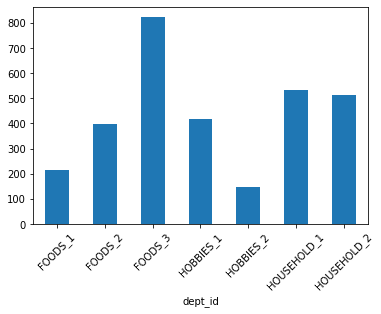

In [11]:
# we can see department FOODS_3 has more items in it but it is not proportional to how many FOODS_3 items were purchased 
# on Christmas
df.groupby('dept_id').item_id.nunique().plot(kind='bar')
plt.xticks(rotation=45)

In [12]:
#we noticed there are 10 stores in 3 states
df.store_id.unique()

array(['CA_1', 'CA_2', 'CA_3', 'CA_4', 'TX_1', 'TX_2', 'TX_3', 'WI_1',
       'WI_2', 'WI_3'], dtype=object)

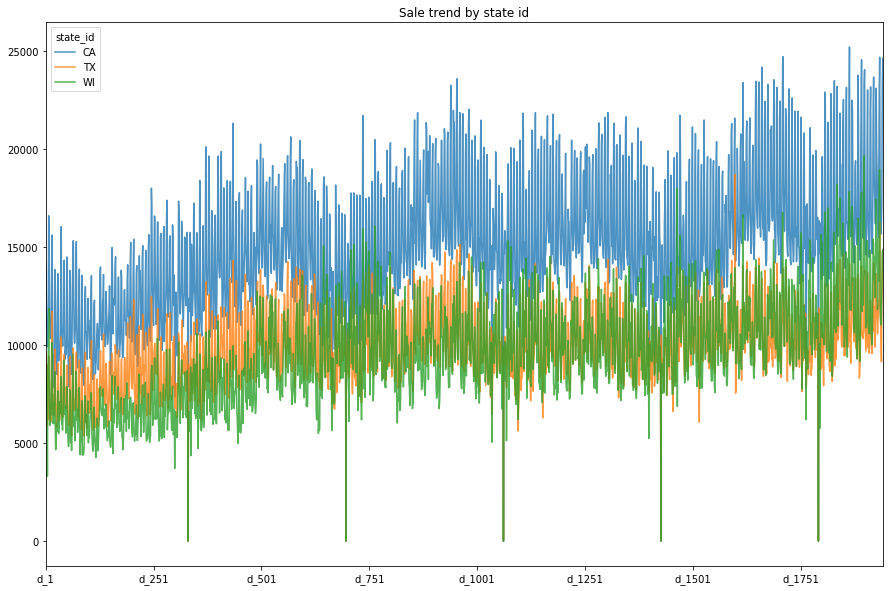

In [13]:
# we can see if there is a huge difference of sales between each state.The largest sale is from CA. While WI was 
#lagged behind TX at the beginning, it caught up towards the end of research period

sale_trend_state = df.groupby('state_id').agg(agg_dict).stack().unstack(level=0)
sale_trend_state.plot(figsize=(15, 10),
              alpha=0.8,
              title='Sale trend by state id')
plt.show()

In [259]:
sale_trend_state

state_id,CA,TX,WI
d_1,14195,9438,8998
d_2,13805,9630,8314
d_3,10108,6778,6897
d_4,11047,7381,6984
d_5,9925,5912,3309
...,...,...,...
d_1937,15678,10375,11043
d_1938,16297,9162,11504
d_1939,17430,12303,12819
d_1940,23103,13681,14734


In [14]:
# Let's load the calendar file which mostly tells us what wm_yr_wk is for each day
calendar = pd.read_csv('/Users/irislu/Downloads/capstone2/m5-forecasting-accuracy/calendar.csv')
calendar

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1964,2016-06-15,11620,Wednesday,5,6,2016,d_1965,NaN,NaN,NaN,NaN,0,1,1
1965,2016-06-16,11620,Thursday,6,6,2016,d_1966,NaN,NaN,NaN,NaN,0,0,0
1966,2016-06-17,11620,Friday,7,6,2016,d_1967,NaN,NaN,NaN,NaN,0,0,0
1967,2016-06-18,11621,Saturday,1,6,2016,d_1968,NaN,NaN,NaN,NaN,0,0,0


In [15]:
# Since the first day starts on Jan 29 rather than Jan 1, we cannot simply cut the last day of the year on Dec 31.
year_day = []
for i in range(6):
    start_date = 11100 + i*100
    stop_date = 11200 + i*100
    year_num = calendar[calendar['wm_yr_wk'].between(start_date, stop_date, inclusive=False)].shape[0]
    year_day.append(year_num)
year_day
# we can see that the first 5 year_day are pretty close to 365 days. Thus, we can use wm_yr_wk to judge which year 
#a record belongs to. This means, if wm_yr_wk is between 11100 and 11200, then the record is from year 1; if between
#11200 and 11300, then the record is from year 2. This will make our work later much easier.

[364, 364, 371, 364, 364, 142]

In [16]:
# And finanlly we load the price doc. It is important since according to the competition guide, it is the only place 
# where you can figure out if the item was actually sold in a store. If there is a price for an item in a store,
#the item is sold there.
price = pd.read_csv('/Users/irislu/Downloads/capstone2/m5-forecasting-accuracy/sell_prices.csv')
price

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26
...,...,...,...,...
6841116,WI_3,FOODS_3_827,11617,1.00
6841117,WI_3,FOODS_3_827,11618,1.00
6841118,WI_3,FOODS_3_827,11619,1.00
6841119,WI_3,FOODS_3_827,11620,1.00


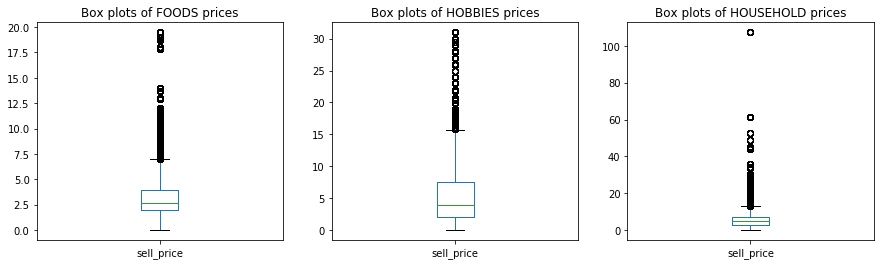

In [17]:
# we want to see the distribution of the prices for each category to see if there are a lot of outliers
fig, axs = plt.subplots(1, 3, figsize=(15, 4))

i = 0
for cat , group in price.merge(df[['item_id','cat_id']], on='item_id').groupby('cat_id'):
                                                                            ax = group['sell_price'].plot(kind='box', 
                                                                                ax=axs[i],title=f'Box plots of {cat} prices')
                                                                            i += 1
                                                                            
                                                                            
                                                                        


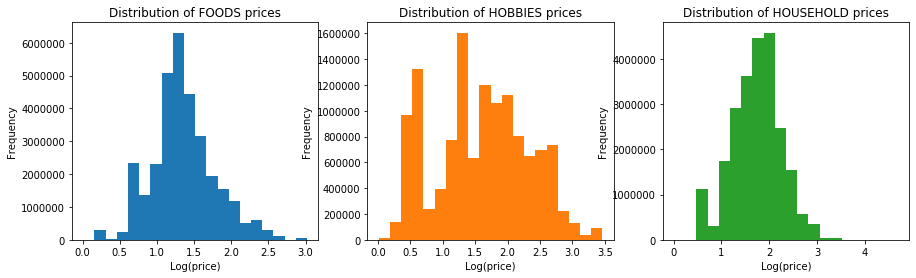

In [18]:
# we now see the price distribution across difference categories
fig, axs = plt.subplots(1, 3, figsize=(15, 4))
color_cycle = itertools.cycle(plt.rcParams['axes.prop_cycle'].by_key()['color']) 
i = 0
for cat , group in price.merge(df[['item_id','cat_id']], on='item_id').groupby('cat_id'):
                                                                            ax = group['sell_price'].apply(np.log1p).plot(kind='hist', 
                                                                                ax=axs[i],bins=20,title=f'Distribution of {cat} prices',
                                                                                                         color=next(color_cycle))
                                                                            i += 1
                                                                            ax.set_xlabel('Log(price)')    


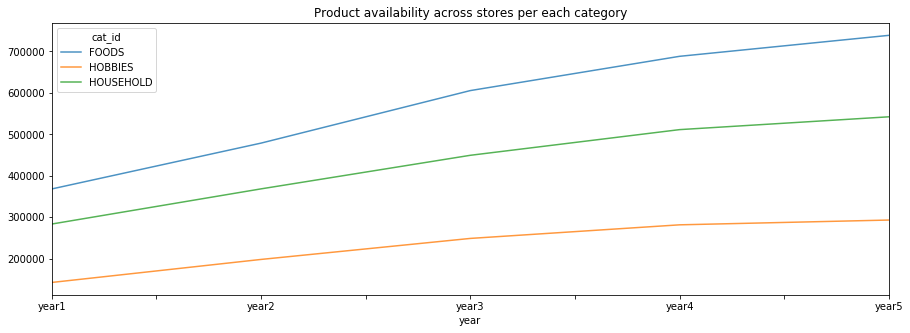

In [19]:
# we use what have learned from calendar to bin the wm_yr_wk into years to better plot the trend
bins = [11100,11200,11300,11400,11500,11600]
label = ['year1','year2','year3','year4','year5']
df_price = df[['item_id','cat_id']].drop_duplicates()
sold_percentage = price.merge(df_price, how='left',on='item_id')
sold_percentage['year'] = pd.cut(sold_percentage['wm_yr_wk'], bins=bins, labels=label)

sold_percentage.groupby(['cat_id','year']).sell_price.count().unstack(level=0).plot(figsize=(15, 5),
    alpha=0.8,title='Product availability across stores per each category')


In [20]:
sold_percentage.groupby(['cat_id','year']).sell_price.count().unstack(level=0)

cat_id,FOODS,HOBBIES,HOUSEHOLD
year,,,
year1,368374,142808,283728
year2,478932,198327,368536
year3,605622,249008,449511
year4,688262,281792,511436
year5,738833,293320,542358


3. Feature aggregation and prepare data for modeling

We will imagine how would our training data look like before we start coding. The information we could obtain from the 3 dataframes above are: 

Dataframe df:5 year of sales(by categoey, by state or by store); 

Dataframe price: it has each item's price for each week, since we are looking at yearly basis, we just need the min, max and average of price of each item for each year. We can also count the weekly price given to caculate how many weeks an item were sold in each store.

Dataframe calendar: for this project, it just acts like a bridge to link day number to wm_yr_wk.

The whole training set will look like this: for the current year, for each item, it will contain 
A. current year' min, max and average price and previous year's min, avg, max price
B. previous year's total selling days for each store for the year(which is certain and happened already), and if in current years, the product will be continue(if the price count for current year is over 0 then yes, equals 0 then no)
C. previous year's sale by store_id and current year's sales number as target.
D. department id category id 
E. if the item can be purchased by SNAP(we assume all the food item is eligible)



In [21]:
# Now we do the data wrangling to get the 5 year's data ready.

#first we start with a empty list for the 5 year's dataframes later
df_list = []
# we start a list to contain the number of days contains in each year, the first element is 6 because d_1 column is 
#6th column in df.
days_num = [6]


for i in range(5):
    #we have decided to use the wm_yr_wk to bin the year number so we set up the start date and stop date for each year
    start_date = 11100 + i*100 
    stop_date = 11200 + i*100
    
    #caculate how many days contains in this year
    year_num = calendar[calendar['wm_yr_wk'].between(start_date, stop_date, inclusive=False)].shape[0]
    #append the days number to days_num list
    days_num.append(year_num)
    
    #group by the item_id, sum up the total daily sales across different stores for this certain year
    sales_by_item = df.groupby('item_id')[df.iloc[:,days_num[i]:days_num[i]+year_num].columns].sum()
    # sum up the daily sales to obtain the yearly sales for each item
    sales_by_item = pd.DataFrame(sales_by_item.sum(axis=1),columns=['sales'])
    
    # we need the department id and category id for each item so we get it here:
    df_ = df[['item_id','dept_id','cat_id']]
    df_.drop_duplicates(inplace=True)
    dff = sales_by_item.merge(df_, how='left', on='item_id',left_index=True)
    
    # we want the sales by store_id so we do that here:
    by_store = df.groupby(['item_id','store_id'])[df.iloc[:,days_num[i]:days_num[i]+year_num].columns].sum()
    by_store = pd.DataFrame(by_store.sum(axis=1),columns=['sales_by_store'])
    by_store = by_store.unstack(level=1)
    dff = dff.merge(by_store, how='left',on='item_id')

    #time to get the price count for each item for each store and (min,max, avg) price
    
    #get the price for the certain weeks for that year
    price_ = price[price['wm_yr_wk'].between(start_date, stop_date, inclusive=False)]
    #caculate the min,max,avg
    price_agg = pd.DataFrame(price_.groupby('item_id').agg({'sell_price': ['mean', 'min', 'max']}))
    #count the weeks that a price is given, which indicates how many weeks that item was sold in each store
    price_count = pd.DataFrame(price_.groupby(['item_id','store_id']).wm_yr_wk.count())
    price_count_unstack = price_count.unstack(level=1)
    
    
    #finally we merge the price count by store to the main dataframe and create a SNAP column and filled the 
    #NAN with 0
    dff = dff.merge(price_count_unstack,on='item_id',how='left').merge(price_agg,on='item_id',how='left')
    dff['SNAP_allowed'] = (dff.dept_id.isin(['FOODS_1','FOODS_2','FOODS_3']))*1
    dff = dff.fillna(0)
    assert (len(dff) == df.item_id.nunique()), 'Not all the item is included here!'
    df_list.append(dff)
    
    

In [23]:
# here we talk a look at the first year's data. Everything looks fine.
df_list[0]

,item_id,sales,dept_id,cat_id,"(sales_by_store, CA_1)","(sales_by_store, CA_2)","(sales_by_store, CA_3)","(sales_by_store, CA_4)","(sales_by_store, TX_1)","(sales_by_store, TX_2)",...,"(wm_yr_wk, TX_1)","(wm_yr_wk, TX_2)","(wm_yr_wk, TX_3)","(wm_yr_wk, WI_1)","(wm_yr_wk, WI_2)","(wm_yr_wk, WI_3)","(sell_price, mean)","(sell_price, min)","(sell_price, max)",SNAP_allowed
0,FOODS_1_001,2775,FOODS_1,FOODS,326,471,497,170,183,257,...,52.0,52.0,51.0,52.0,52.0,52.0,1.999037,1.75,2.00,1
1,FOODS_1_002,1348,FOODS_1,FOODS,292,72,126,111,88,100,...,51.0,52.0,52.0,52.0,52.0,52.0,8.180925,7.66,8.88,1
2,FOODS_1_003,3138,FOODS_1,FOODS,318,732,353,251,180,184,...,52.0,52.0,52.0,52.0,52.0,52.0,2.880000,2.88,2.88,1
3,FOODS_1_004,0,FOODS_1,FOODS,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00,0.00,1
4,FOODS_1_005,5590,FOODS_1,FOODS,643,1500,1098,165,306,320,...,52.0,52.0,52.0,52.0,52.0,49.0,3.104603,2.50,3.28,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3044,HOUSEHOLD_2_512,2254,HOUSEHOLD_2,HOUSEHOLD,279,499,389,147,136,199,...,52.0,52.0,50.0,52.0,52.0,52.0,3.972335,3.97,4.27,0
3045,HOUSEHOLD_2_513,0,HOUSEHOLD_2,HOUSEHOLD,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00,0.00,0
3046,HOUSEHOLD_2_514,629,HOUSEHOLD_2,HOUSEHOLD,117,132,48,52,25,82,...,51.0,52.0,52.0,52.0,50.0,52.0,18.984855,15.00,20.97,0
3047,HOUSEHOLD_2_515,0,HOUSEHOLD_2,HOUSEHOLD,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00,0.00,0


In [24]:
#what we got from df_list is 5 dataframes for year1-year2. Now we will merge them one by one and get 4 combined 
#dataframes at last.  
training_list = []
for i in range(4):
    #For previous year, we need everything other than the 'sales','dept_id','SNAP_allowed' columns. We don't need 
    #previous sales and other info will be included in the current year data.
    df_previous = df_list[i].drop(['sales','dept_id','SNAP_allowed','cat_id'],axis=1)
    
    #For current year, we don't need the current sales by store we have the gross sale as target already, so we drop 
    #the 10 columns here
    df_current = df_list[i+1].drop(df_list[i+1].iloc[:,4:14].columns,axis=1)
    assert (len(df_current.columns)==18),'something wrong with the current year columns number!'
    
    #now we need to process the sold days of current year to yes or no, if days is over 0 then 1, if equals 0 then 0
    df_current.iloc[:,4:14] = df_current.iloc[:,4:14].where(df_current.iloc[:,4:14]==0,1)
    # change the current sales column name to 'target'
    df_current.rename(columns={'sales':'target'},inplace=True)
    df_combined = df_previous.merge(df_current,how='inner',on='item_id')
    df_combined = df_combined.fillna(0)
    assert (len(df_combined.columns) == 41), 'Not right number of columns!'
    training_list.append(df_combined)

In [26]:
# Here we split the data to train_set and test_set. Because we have to make sure for each item, its four year data 
#should be a whole package and is either in train or in test and should never seperate.


np.random.seed(24)
# we just get the draw random 70% of 3049 items to be train_set. We get the fixed row number sets for each of the four
#years and because the item order for each year is the same, we can make sure we all the same items records go to
#either train or test set
shuffled_indices = np.random.permutation(df.item_id.nunique())
test_set_size = int(df.item_id.nunique() * 0.3)
test_indices = shuffled_indices[:test_set_size]
train_indices = shuffled_indices[test_set_size:]

train_set = pd.concat([data.iloc[train_indices] for data in training_list])
test_set = pd.concat([data.iloc[test_indices] for data in training_list])

assert (train_set.item_id.nunique() + test_set.item_id.nunique() == 3049), 'There is somthing wrong with the train, test split!'

In [27]:
# Now we want to make sure this random process won't happen to make the train and test sets very different in
#distribution. The average of the target is very close so it is fine.
print(train_set.target.mean())
print(test_set.target.mean())

3918.3934426229507
4143.143326039387


In [29]:
#take a look on the columns after merge
test_set.columns

Index([                 'item_id', ('sales_by_store', 'CA_1'),
       ('sales_by_store', 'CA_2'), ('sales_by_store', 'CA_3'),
       ('sales_by_store', 'CA_4'), ('sales_by_store', 'TX_1'),
       ('sales_by_store', 'TX_2'), ('sales_by_store', 'TX_3'),
       ('sales_by_store', 'WI_1'), ('sales_by_store', 'WI_2'),
       ('sales_by_store', 'WI_3'),   '('wm_yr_wk', 'CA_1')_x',
         '('wm_yr_wk', 'CA_2')_x',   '('wm_yr_wk', 'CA_3')_x',
         '('wm_yr_wk', 'CA_4')_x',   '('wm_yr_wk', 'TX_1')_x',
         '('wm_yr_wk', 'TX_2')_x',   '('wm_yr_wk', 'TX_3')_x',
         '('wm_yr_wk', 'WI_1')_x',   '('wm_yr_wk', 'WI_2')_x',
         '('wm_yr_wk', 'WI_3')_x', '('sell_price', 'mean')_x',
        '('sell_price', 'min')_x',  '('sell_price', 'max')_x',
                         'target',                  'dept_id',
                         'cat_id',   '('wm_yr_wk', 'CA_1')_y',
         '('wm_yr_wk', 'CA_2')_y',   '('wm_yr_wk', 'CA_3')_y',
         '('wm_yr_wk', 'CA_4')_y',   '('wm_yr_wk', 'TX_

In [30]:
#buiding the pipeline to process the columns before fitting
num_cols = list(itertools.chain(*[list(range(1,24)),list(range(37,40))]))
cat_cols = list(itertools.chain(*[list(range(25,27))]))
unchanged = list(itertools.chain(*[[40],list(range(27,37))]))


assert (len(num_cols) + len(cat_cols) + len(unchanged) == 39),'Somthing wrong with the feature seperation!'

In [166]:

pipeline = ColumnTransformer([('num',StandardScaler(),num_cols),
                              ('cat', OneHotEncoder(),cat_cols),
                              ('unchanged','passthrough',unchanged)])

In [167]:
#there are 47 columns after the pipeline
train_set_prepared = pipeline.fit_transform(train_set)
len(train_set_prepared[0])

47

In [168]:
X_train = train_set_prepared
y_train = train_set.target

X_test = pipeline.transform(test_set)
y_test = test_set.target

4. Setting up models and evaluation metrics
Now it is the modeling session. We have chosen RMSE as our metrics and R2 as a reference on the side for linear models comparision 

In [ ]:
A. Linear Regressor 

In [34]:
lin_reg = LinearRegression(fit_intercept=False)

B. Ridge Regressor 

In [35]:
ridge_reg = Ridge(fit_intercept=False,random_state = 24)

In [ ]:
C. Lasso Regressor 

In [40]:
lasso_reg = Lasso(fit_intercept=False,random_state = 24)

In [ ]:
D. SVM Linear Regressor/E. SVM Polynomial Regressorm

In [151]:
svm_reg = LinearSVR()


svm_poly_reg = SVR(kernel='poly')

E. SVM Polynomial Regressor

In [37]:
tree_reg = DecisionTreeRegressor(random_state = 24)

G. Random Forest Regressor

In [38]:
rf_reg = RandomForestRegressor(random_state = 24)

H. Adaboost Regressor

In [39]:
ada_reg = AdaBoostRegressor(random_state = 24)

In [41]:
# we first compare the first 8 models and will set up the neural networks later 

models_dict = OrderedDict()

models_dict['Linear'] = lin_reg
models_dict['Ridge'] = ridge_reg
models_dict['Lasso'] = lasso_reg
models_dict['SVM Linear'] = svm_reg
models_dict['SVM Polynomial'] = svm_poly_reg
models_dict['Decision Tree'] = tree_reg
models_dict['Random Forest'] = rf_reg
models_dict['AdaBoost'] = ada_reg

In [42]:
#set up cross validation 
def select_model(X, y, models):
    model_results = OrderedDict()
    
    for model_name, model in models.items():
        
        metrics = OrderedDict()
        
        scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
        
        metrics['rmse_ave'] = np.sqrt(-scores).mean()
        
        
        metrics['rmse_std'] = np.sqrt(-scores).std()
        
        r2 = cross_val_score(model, X, y, cv=5, scoring='r2')
        
        metrics['r2'] = r2.mean()
        
        
    
        
        model_results[model_name] = metrics
        
    return model_results

In [152]:
#it seems all the linear models are good. We will drop SVM polynomial, Decision Tree and Adaboost because it is worse
#than the benchmark we calculated below
pd.DataFrame(select_model(X=train_set_prepared, y=train_set.target,models=models_dict))

,Linear,Ridge,Lasso,SVM Linear,SVM Polynomial,Decision Tree,Random Forest,AdaBoost
rmse_ave,1945.555157,1945.424476,1945.251721,2774.453860,6661.813208,2695.862273,2014.280308,4794.521778
rmse_std,1730.400948,1730.172682,1730.810238,1497.187682,941.197487,1651.741538,1864.869318,1303.995865
r2,0.939509,0.939520,0.939509,0.911339,0.582614,0.910048,0.933303,0.772230


In [47]:
#set the benchmark for rmse, see what is the rmse if we simply predict the target to the same as previous year sales
sum_col = train_set.iloc[:,1]+train_set.iloc[:,2]+train_set.iloc[:,3]+train_set.iloc[:,4]+train_set.iloc[:,5]\
          +train_set.iloc[:,6]+train_set.iloc[:,7]+train_set.iloc[:,8]+train_set.iloc[:,9]+train_set.iloc[:,10]
sum_col

133      1796
2171      726
818      1628
1837     2998
71       3133
        ...  
2193     8372
343       306
2240        0
899      2658
418     13081
Length: 8540, dtype: int64

In [52]:
mse = mean_squared_error(train_set.target, sum_col)

rmse = np.sqrt(mse)
rmse

2545.91556112519

I. Neural Networks
Finally let's take a look at neural networks

In [156]:
def baseline_model():

    model = Sequential()
    model.add(Dense(47, input_dim=47, kernel_initializer='normal', activation='relu'))
    model.add(Dense(1, kernel_initializer='normal'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

estimator = KerasRegressor(build_fn=baseline_model, epochs=100, batch_size=10, verbose=0)

results = cross_val_score(estimator,X_train,y_train, cv=3,scoring='neg_mean_squared_error')


print(np.sqrt(-results).mean(), np.sqrt(-results).std())


2079.9843017075555 1669.693850892006


In [158]:
# the model performed pretty well so we will keep it
scores = cross_val_score(estimator, X_train,y_train, cv=3, scoring='r2')
print(scores.mean())

0.9278408059928288


5. Fine_tuning hyperparameters

In [149]:
# There is no parameters we can tune for linear regression so we will start with ridge
ridge_reg_tuned = Ridge(fit_intercept=False,random_state = 24)

param_grid = {'alpha':[30,35,40,45],
              'max_iter':[None,1,2],
              'solver':['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
               }
grid_ridge = GridSearchCV(ridge_reg_tuned,param_grid, cv=5,scoring = 'neg_mean_squared_error')

grid_ridge.fit(X_train, y_train)

grid_ridge.best_params_

{'alpha': 40, 'max_iter': None, 'solver': 'svd'}

In [133]:
#Lasso
lasso_reg_tuned = Lasso(fit_intercept=False,random_state = 24)

param_grid = {'alpha':[2.5,3,3.5],
              'max_iter':[50,100,150],
              'warm_start':[True,False],
              'selection':['cyclic', 'random']
               }
grid_lasso = GridSearchCV(lasso_reg_tuned,param_grid, cv=5,scoring = 'neg_mean_squared_error')

grid_lasso.fit(X_train, y_train)

grid_lasso.best_params_

{'alpha': 3, 'max_iter': 100, 'selection': 'random', 'warm_start': True}

In [136]:
#SVM linear
svm_reg_tuned = LinearSVR(fit_intercept=False)

param_grid = {'epsilon':[0.8,1,1.2],
              'C':[40,50,60],
              #'loss':['epsilon_insensitive', 'squared_epsilon_insensitive'],
              #'dual':[True, False],
              'max_iter':[2000,2200,2500]
              }
grid_svm = GridSearchCV(svm_reg_tuned,param_grid, cv=5,scoring = 'neg_mean_squared_error')

grid_svm.fit(X_train, y_train)

grid_svm.best_params_

{'C': 50, 'epsilon': 1, 'max_iter': 2500}

In [142]:
#Random Forest 
rf_reg_tuned = RandomForestRegressor(random_state = 24,criterion='mae',max_features='sqrt',n_estimators= 10,
                                     min_samples_split=4)

param_grid = {##'n_estimators':[5,10,20,30],
              ##'criterion':['mse', 'mae'],
              ##'max_depth':[None,5,10],
              ##'min_samples_split':[4,6,8],
              ##'min_samples_leaf':[1,5],
              ##'min_weight_fraction_leaf':[0,0.1,0.2],
              ##'max_features':['auto', 'sqrt', 'log2'],
              ##'max_leaf_nodes':[None,1,5],
              'min_impurity_decrease':[0,0.1,0.5,0.7],
              'bootstrap':[True,False],
              ##'oob_score':[True,False],
              
              'warm_start':[True,False],
              'ccp_alpha':[0,0.1,0.5],
              'max_samples':[None,1,10]
              
              }
randomCV_rf = RandomizedSearchCV(rf_reg_tuned,param_grid, n_iter=100,cv=3,
                              scoring = 'neg_mean_squared_error',random_state=24)


randomCV_rf.fit(X_train, y_train)

randomCV_rf.best_params_

{'warm_start': True,
 'min_impurity_decrease': 0.1,
 'max_samples': 1,
 'ccp_alpha': 0.1,
 'bootstrap': False}

In [121]:
# neural networks
np.random.seed(24)
params = {'activation': ["relu", "tanh"],
          'epochs': [50,100],
           'dropout_rate' : [0.0, 0.2, 0.4, 0.6]}
def create_model(activation='relu',dropout_rate=0.0, weight_constraint=0):
    model = Sequential()
    model.add(Dense(50, input_dim=47, activation=activation,kernel_initializer='normal'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, kernel_initializer='normal'))

    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

estimator = KerasRegressor(build_fn=create_model,batch_size=20, verbose=0)


randomCV = RandomizedSearchCV(estimator,params, n_iter=500,n_jobs=1,cv=3,
                              scoring = 'neg_mean_squared_error',random_state=24)
result = randomCV.fit(X_train, y_train)

print(result.best_score_, result.best_params_)

-27150670.755234722 {'epochs': 100, 'dropout_rate': 0.0, 'activation': 'relu'}


In [127]:
# after tuning some hyperparamters, we can finally tune the learning rate since learning rate changes as other 
#parameters change
def create_model(learn_rate=0.01):
    model = Sequential()
    model.add(Dense(50, input_dim=47, activation='relu',kernel_initializer='normal'))
    model.add(Dense(1, kernel_initializer='normal'))

    optimizer = SGD(lr=learn_rate)
    model.compile(loss='mean_squared_error', optimizer=optimizer)
    return model

estimator = KerasRegressor(build_fn=create_model, epochs=100, batch_size=100, verbose=0)
params ={'learn_rate' : [0.000001,0.00001,0.0001]}

grid = GridSearchCV(estimator=estimator, param_grid=params, n_jobs=1,cv=3)
grid_result_nn = grid.fit(X_train, y_train)

print(grid_result_nn.best_score_, grid_result_nn.best_params_)


-7124483.166518464 {'learn_rate': 1e-06}


6. Evaluate final models on test set

In [159]:
# we set up so the best 6 models after tuning can be compared using held-out test data
lin_reg.fit(X_train,y_train)

def select_final_model(X, y, models):
    model_results = OrderedDict()
    
    for model_name, model in models.items():
        metrics = OrderedDict()
       
        y_pred = model.predict(X)
        
        metrics['rmse'] = np.sqrt(mean_squared_error(y,y_pred))
        
        metrics['r2'] = r2_score(y,y_pred)
        
        model_results[model_name] = metrics
        
    return model_results

model_final = {'Linear':lin_reg,'Ridge':grid_ridge.best_estimator_,
               'Lasso':grid_lasso.best_estimator_,'SVM':grid_svm.best_estimator_,
               'RandomForest':randomCV_rf.best_estimator_,
               'Neural Network':grid_result_nn.best_estimator_}

pd.DataFrame(select_final_model(X_test, y_test, models=model_final))

,Linear,Ridge,Lasso,SVM,RandomForest,Neural Network
rmse,2211.482855,2209.944304,2213.659682,2254.695149,2571.690058,2211.142671
r2,0.942433,0.942513,0.942320,0.940161,0.922153,0.942451


In [ ]:
# It is easy to see that Ridge is the best model

7. Result and feature importance analysis

Since Ridge is linear model and the numeric columns have been scaled, we can simply look at the absolute value of the coefficients to see which features are the most important

In [207]:
num_coeffcient = grid_ridge.best_estimator_.coef_[:26]

In [208]:
num_col_name = np.concatenate((test_set.columns[1:24],test_set.columns[-4:-1]))

In [255]:
assert (len(num_coeffcient) == len(num_col_name)), 'smomthing wrong with the column matching！'

dict(zip(num_col_name,np.abs(num_coeffcient)))

# we can see for numeric features, the previous year's sale is very important

{('sales_by_store', 'CA_1'): 1036.9992404190227,
 ('sales_by_store', 'CA_2'): 495.4702565903997,
 ('sales_by_store', 'CA_3'): 2529.465185215305,
 ('sales_by_store', 'CA_4'): 813.2565926966034,
 ('sales_by_store', 'TX_1'): 1266.082258529133,
 ('sales_by_store', 'TX_2'): 1100.440052577149,
 ('sales_by_store', 'TX_3'): 1432.1033411104677,
 ('sales_by_store', 'WI_1'): 506.9617059961861,
 ('sales_by_store', 'WI_2'): 438.88118628130263,
 ('sales_by_store', 'WI_3'): 1555.2961563154201,
 "('wm_yr_wk', 'CA_1')_x": 18.29616545677709,
 "('wm_yr_wk', 'CA_2')_x": 46.81406533587278,
 "('wm_yr_wk', 'CA_3')_x": 18.85397953351628,
 "('wm_yr_wk', 'CA_4')_x": 6.860325245922354,
 "('wm_yr_wk', 'TX_1')_x": 186.38658995714155,
 "('wm_yr_wk', 'TX_2')_x": 94.64374729206247,
 "('wm_yr_wk', 'TX_3')_x": 124.05281431378296,
 "('wm_yr_wk', 'WI_1')_x": 6.153350776889511,
 "('wm_yr_wk', 'WI_2')_x": 77.69686517169794,
 "('wm_yr_wk', 'WI_3')_x": 113.05505539437297,
 "('sell_price', 'mean')_x": 192.2784991498387,
 "('s

In [211]:
#while for categoric features, obviously which category the item belongs to play an important role
encoder = OneHotEncoder()
encoder.fit(train_set.iloc[:,25:27])
cat_col_name = np.concatenate((encoder.get_feature_names(),test_set.columns[-1],test_set.columns[27:37]),axis=None)
cat_coeffcient = grid_ridge.best_estimator_.coef_[26:]

assert (len(cat_coeffcient) == len(cat_col_name)),'smomthing wrong with the column matching！'

dict(zip(cat_col_name,cat_coeffcient))

{'x0_FOODS_1': 552.3706068040053,
 'x0_FOODS_2': 33.123342358492266,
 'x0_FOODS_3': 431.79320473161573,
 'x0_HOBBIES_1': 734.6932799776991,
 'x0_HOBBIES_2': 630.6716793779092,
 'x0_HOUSEHOLD_1': 878.632511027161,
 'x0_HOUSEHOLD_2': 652.5969148914683,
 'x1_FOODS': 1017.2871538940971,
 'x1_HOBBIES': 1365.3649593556054,
 'x1_HOUSEHOLD': 1531.2294259186265,
 'SNAP_allowed': 1017.2871538940976,
 "('wm_yr_wk', 'CA_1')_y": -92.26299739695406,
 "('wm_yr_wk', 'CA_2')_y": 151.17764922329314,
 "('wm_yr_wk', 'CA_3')_y": 27.956636532597827,
 "('wm_yr_wk', 'CA_4')_y": -62.277805418286505,
 "('wm_yr_wk', 'TX_1')_y": 350.95547492763956,
 "('wm_yr_wk', 'TX_2')_y": 312.971621195018,
 "('wm_yr_wk', 'TX_3')_y": 271.96583974690736,
 "('wm_yr_wk', 'WI_1')_y": 247.4989438029427,
 "('wm_yr_wk', 'WI_2')_y": 275.18388820722566,
 "('wm_yr_wk', 'WI_3')_y": 313.60735860042644}

8. Reference
[1] https://www.analyticsvidhya.com/blog/2015/06/correlation-common-questions/

[2] https://machinelearningmastery.com/regression-tutorial-keras-deep-learning-library-python/

[3] https://www.oxfordeagle.com/2016/12/24/what-time-does-walmart-close-tonight-christmas-eve-2016/#:~:text=Walmart%20closes%20at%206%20p.m.,usually%20closes%20on%20Christmas%20Eve.

[4] https://www.skubana.com/blog/walmart-leading-way

[5] https://www.kaggle.com/headsortails/back-to-predict-the-future-interactive-m5-eda

[6] https://www.kaggle.com/robikscube/m5-forecasting-starter-data-exploration
